In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/home/ci411/volume_estimation')
import eval_funcs
import model_funcs
import pandas as pd
import torch
from IPython.display import IFrame
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Using device: cpu

Using device: cpu


Model prop0_20k_081622 has completed 1000 epochs
Model prop1_20k_081622 has completed 1000 epochs
Model prop2_20k_081622 has completed 1000 epochs
Model prop3_20k_081622 has completed 1000 epochs
Model prop4_20k_081622 has completed 1000 epochs
Model prop5_20k_081622 has completed 1000 epochs
Model prop6_20k_081622 has completed 1000 epochs


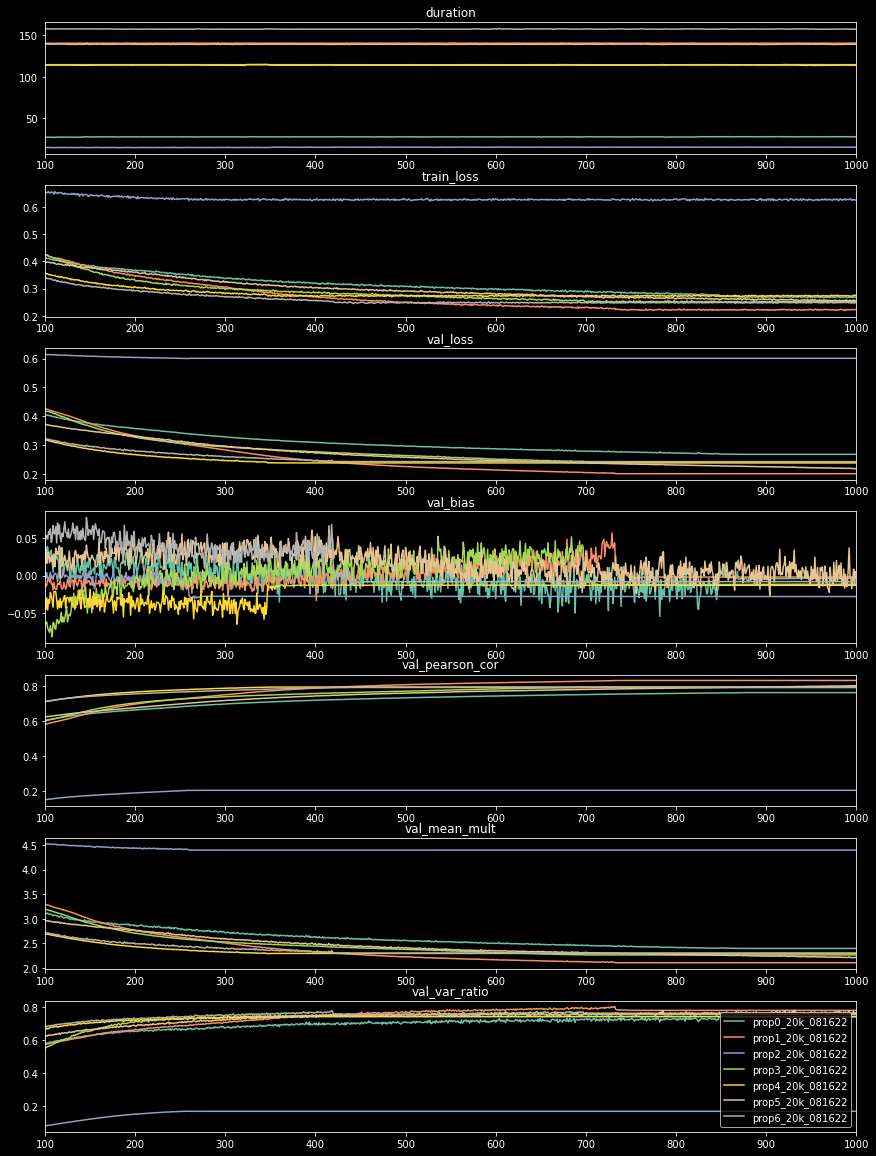

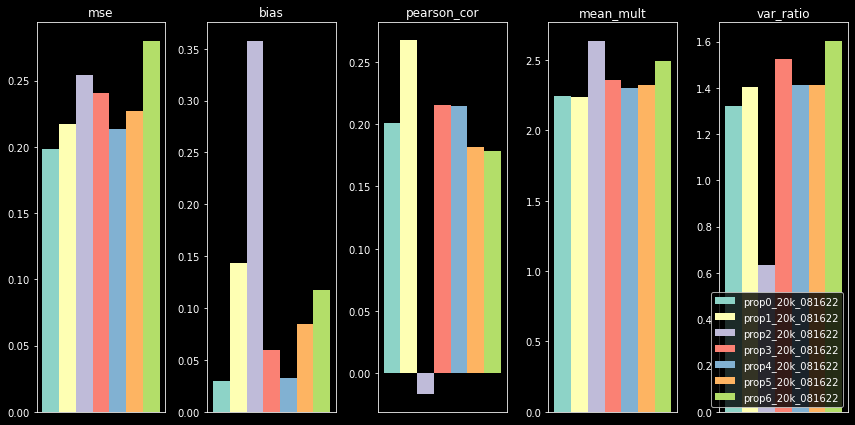

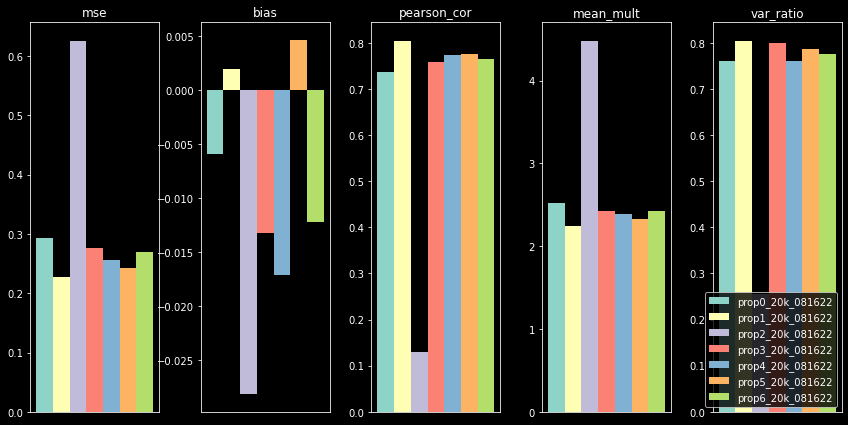

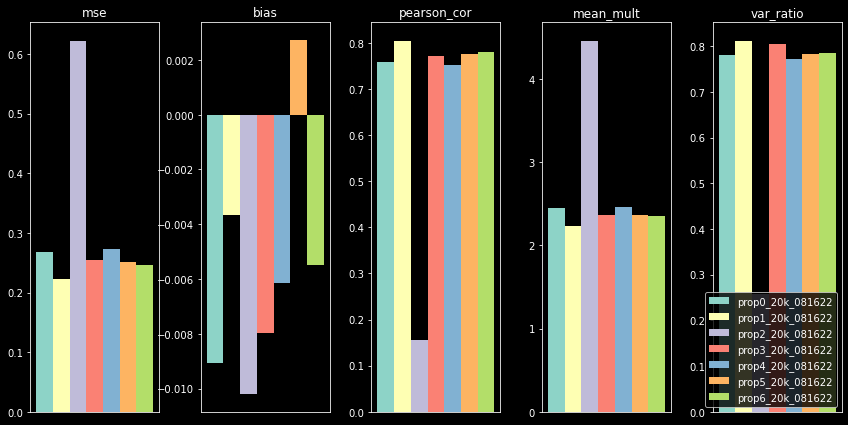

In [2]:
experiment_name = '20k_comp_models'
plt.style.use('dark_background')
fig_curves = eval_funcs.plot_experiment_curves(experiment_name, offset=100, cmap='Set2')
test_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='test')
val_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='val')
train_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='train')


Model:prop0_20k_081622	 Metric:mse	 Val:0.29225235989114584
Model:prop0_20k_081622	 Metric:bias	 Val:-0.005893742069640021
Model:prop0_20k_081622	 Metric:pearson_cor	 Val:0.7363396890840569
Model:prop0_20k_081622	 Metric:mean_mult	 Val:2.518489461601205
Model:prop0_20k_081622	 Metric:var_ratio	 Val:0.7616049201305767
Model:prop1_20k_081622	 Metric:mse	 Val:0.22720386474969487
Model:prop1_20k_081622	 Metric:bias	 Val:0.0019718078380884197
Model:prop1_20k_081622	 Metric:pearson_cor	 Val:0.8039669695243764
Model:prop1_20k_081622	 Metric:mean_mult	 Val:2.242560150227467
Model:prop1_20k_081622	 Metric:var_ratio	 Val:0.8040203724062476
Model:prop2_20k_081622	 Metric:mse	 Val:0.6253988366802644
Model:prop2_20k_081622	 Metric:bias	 Val:-0.028164265516944165
Model:prop2_20k_081622	 Metric:pearson_cor	 Val:0.13028915387281914
Model:prop2_20k_081622	 Metric:mean_mult	 Val:4.477944219145145
Model:prop2_20k_081622	 Metric:var_ratio	 Val:0.2550850126803811
Model:prop3_20k_081622	 Metric:mse	 Val:0.2

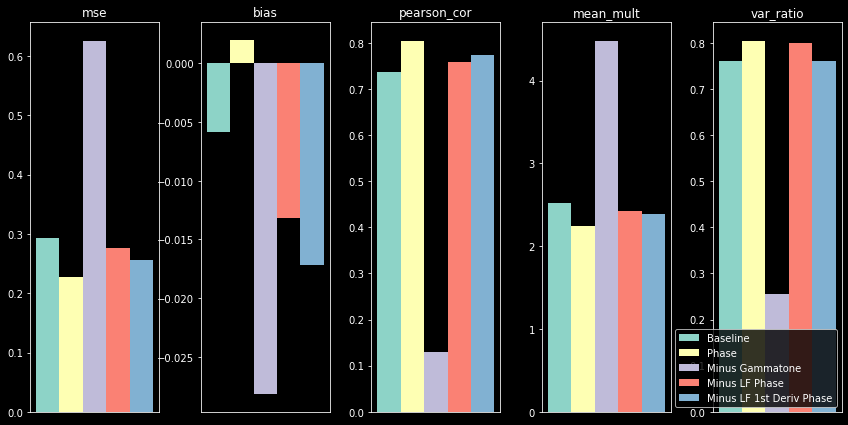

In [13]:
MODELS_DIR = '/scratch/ci411/sonos_rirs/models/'
import json
def plot_experiment_metrics(experiment_name, model_names=None, split='test'):
    experiment_dir = os.path.join(MODELS_DIR, experiment_name)
    
    if model_names is None:
        model_names = os.listdir(experiment_dir)
        model_names.sort()
            
    n = len(model_names)
    width = 0.5/n
    
    fig, axs = plt.subplots(1,5, figsize=(12,6))
    fig.tight_layout()

    for i, model in enumerate(model_names):
        json_metric = os.path.join(experiment_dir, model, '{}_metrics.json'.format(split))
        if os.path.exists(json_metric):
            with open(json_metric) as f:
                metric_dict = json.load(f)
        else:
            print("No metric file at {}".format(json_metric))
            continue
        
        offset = i/(2*n) - 0.25
        for j, (key, val) in enumerate(metric_dict.items()):
            axs[j].bar(offset, val, width, label=model)
            axs[j].set_title(key)
            axs[j].set_xticks([])
            print("Model:{}\t Metric:{}\t Val:{}".format(model, key, val))
    #plt.legend(loc='lower right')
    return fig
model_names = ['prop0_20k_081622', 'prop1_20k_081622','prop2_20k_081622','prop3_20k_081622','prop4_20k_081622']
val_metrics = plot_experiment_metrics(experiment_name, model_names=model_names, split='val')

plt.legend(labels=['Baseline', 'Phase', 'Minus Gammatone', 'Minus LF Phase', 'Minus LF 1st Deriv Phase'], loc='lower right')

In [3]:
import pandas as pd
import model_funcs
import torch
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODELS_DIR = '/scratch/ci411/sonos_rirs/models/'

def re_evaluate_experiment(experiment_name, model_list=None, log=False, same_features=True, gen_plots=False):
    
    if model_list is None:
        model_list = os.listdir(os.path.join(MODELS_DIR, experiment_name))
        model_list.sort()
    
    if same_features:
        _, model_spec, _ = eval_funcs.get_model_hist_spec_state(model_list[0], experiment_name)
        feature_df = pd.read_csv(model_spec['data_path'])
        test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'], log=log)
        del feature_df

        features, labels = next(iter(test_dataloader))
        input_height = features.size()[2]
        input_width = features.size()[3]

        model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
    
    for model_name in model_list:
        print("Loading {}".format(model_name))
        _, model_spec, model_state = eval_funcs.get_model_hist_spec_state(model_name, experiment_name)
        
        if not same_features:
            print("Loading features from {}".format(model_spec['data_path']))
            feature_df = pd.read_csv(model_spec['data_path'])
            test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'], log=log)
            val_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='val'], log=log)
            train_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='train'], log=log)
            del feature_df
            features, labels = next(iter(test_dataloader))
            input_height = features.size()[2]
            input_width = features.size()[3]
            model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
        
        if os.path.exists(model_state):
            model.load_state_dict(torch.load(model_state, map_location=device))
        else:
            print("No weights found for {}".format(model_name))
            continue
        
        print("Computing metrics on {}".format(model_name))
        
        test_metrics = eval_funcs.compute_eval_metrics(test_dataloader, model, log=log)
        test_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'test_metrics.json')
        print('Saving metrics to {}'.format(test_path))
        with open(test_path, 'w') as f:
            json.dump(test_metrics, f)
        
        del test_dataloader
        
        val_metrics = eval_funcs.compute_eval_metrics(val_dataloader, model, log=log)
        val_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'val_metrics.json')
        print('Saving metrics to {}'.format(test_path))
        with open(val_path, 'w') as f:
            json.dump(val_metrics, f)
            
        del val_dataloader
        
        train_metrics = eval_funcs.compute_eval_metrics(train_dataloader, model, log=log)
        train_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'train_metrics.json')
        print('Saving metrics to {}'.format(train_path))
        with open(train_path, 'w') as f:
            json.dump(train_metrics, f)
            
        del train_dataloader
        
        if gen_plots:
            print("Generating confusion matrices...")
            _ = eval_funcs.generate_confusion_plot(experiment_name, model_name, dataloader=test_dataloader, log=log,\
                                                   verbose=False, savepath=os.path.join(model_spec['model_path'], 'test_cm.pdf'))
            _ = eval_funcs.generate_confusion_plot(experiment_name, model_name, split='val', log=log,\
                                                   verbose=False, savepath=os.path.join(model_spec['model_path'], 'val_cm.pdf'))
            _ = eval_funcs.generate_confusion_plot(experiment_name, model_name, split='train', log=log,\
                                               verbose=False, savepath=os.path.join(model_spec['model_path'], 'train_cm.pdf'))

    return None

In [4]:
%load_ext memory_profiler

In [5]:
log = True
model_name = 'prop0_20k_081622'
_, model_spec, model_state = eval_funcs.get_model_hist_spec_state(model_name, experiment_name)

In [6]:
%memit feature_df = pd.read_csv(model_spec['data_path'])

peak memory: 314.93 MiB, increment: 42.35 MiB


In [7]:
#%memit test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'], log=log)

In [8]:
#%memit val_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='val'], log=log)

In [9]:
#%memit train_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='train'], log=log)

In [14]:
small_dataloader = model_funcs.create_dataloader(feature_df.sample(5000), log=log)

features, labels = next(iter(small_dataloader))
input_height = features.size()[2]
input_width = features.size()[3]
model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
model.load_state_dict(torch.load(model_state, map_location=device))

<All keys matched successfully>

In [15]:
%%file compute_metrics.py
import os
import json
import sys
sys.path.append("/home/ci411/volume_estimation/")

import model_funcs
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm 

from tqdm import tqdm

from eval_funcs import *

def compute_eval_metrics(dataloader, model, log=True):
    target_sum = 0
    pred_sum = 0
    n_steps = 0
    print("Computing sums...")
    for (x,y) in tqdm(dataloader):        
        (x, y) = (x.to(device), y.to(device))
        y = y.item()
        pred = model(x).item()
        target_sum += np.sum(y)
        pred_sum += np.sum(pred)
        n_steps += 1
        del x, y
    
    torch.cuda.empty_cache()

    target_mean = target_sum/n_steps
    pred_mean = pred_sum/n_steps
    
    mse = 0
    mean_error = 0
    cov = 0
    abs_log_ratio = 0
    
    var_pred = 0 #technically var * N but gets cancelled out in Pearson calculation
    var_target = 0 
    
    print("Computing metrics...")
    for (x,y) in tqdm(dataloader):        
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        mse += MSE(pred, y).item()
        mean_error += Bias(pred, y).item()
        cov += CovStep(pred, y, pred_mean, target_mean).item()
        abs_log_ratio += MeanAbsLogStep(pred, y, log=log).item()
        
        var_pred += MSE(pred, pred_mean).item()
        var_target += MSE(y, target_mean).item()
        del x, y
        
    out_dict = {}
    out_dict['mse'] = (mse / n_steps)
    out_dict['bias'] = (mean_error / n_steps)
    out_dict['pearson_cor'] = (cov/(np.sqrt(var_pred) * np.sqrt(var_target)))
    out_dict['mean_mult'] = (np.exp(abs_log_ratio/n_steps))
    out_dict['var_ratio'] = (np.sqrt(var_pred) / np.sqrt(var_target))
    
    return out_dict

Overwriting compute_metrics.py


In [16]:
from compute_metrics import compute_eval_metrics

In [17]:
%mprun -f compute_eval_metrics compute_eval_metrics(small_dataloader, model, log=log)

Computing sums...


100%|██████████| 5000/5000 [01:36<00:00, 52.08it/s]


Computing metrics...


100%|██████████| 5000/5000 [01:39<00:00, 50.07it/s]

Filename: /home/ci411/volume_estimation/compute_metrics.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    21   4707.7 MiB   4707.7 MiB           1   def compute_eval_metrics(dataloader, model, log=True):
    22   4707.7 MiB      0.0 MiB           1       target_sum = 0
    23   4707.7 MiB      0.0 MiB           1       pred_sum = 0
    24   4707.7 MiB      0.0 MiB           1       n_steps = 0
    25   4707.7 MiB      0.0 MiB           1       print("Computing sums...")
    26   4852.6 MiB     64.1 MiB        5001       for (x,y) in tqdm(dataloader):        
    27   4852.6 MiB      0.0 MiB        5000           (x, y) = (x.to(device), y.to(device))
    28   4852.6 MiB      0.0 MiB        5000           y = y.item()
    29   4852.6 MiB     80.8 MiB        5000           pred = model(x).item()
    30   4852.6 MiB      0.0 MiB        5000           target_sum += np.sum(y)
    31   4852.6 MiB      0.0 MiB        5000           pred_sum += np.sum(pred)
    32   4852.6 M